# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [73]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

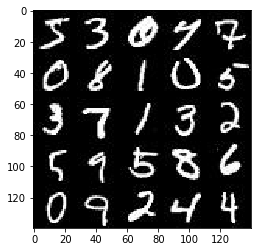

In [74]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

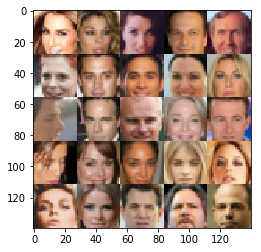

In [75]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [77]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_ph = tf.placeholder(tf.float32, None, name= 'learn_ph')
    return input_real, input_z,learn_ph

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [78]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        layer_one = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid', 
                                     kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_one = tf.maximum(0.1 * layer_one, layer_one)
        # 12x12x64

        layer_two = tf.layers.conv2d(layer_one, 128, 5, strides=2, padding='valid',
                                     kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_two = tf.layers.batch_normalization(layer_two, training=True)
        layer_two = tf.maximum(0.1 * layer_two, layer_two)
        # 4x4x128

        layer_three = tf.layers.conv2d(layer_two, 256, 5, strides=2, padding='same',
                                      kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_three = tf.layers.batch_normalization(layer_three, training=True)
        layer_three = tf.maximum(0.1 * layer_three, layer_three)
        # 2x2x256

        # Flatten it
        layer_three = tf.nn.dropout(layer_three, 0.9)
        flattened = tf.reshape(layer_three, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [79]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        # Fully connected - 4*4*256 output
        layer_one = tf.layers.dense(z, 2*2*256)
        layer_one = tf.reshape(layer_one, (-1, 2, 2, 256))
        layer_one = tf.layers.batch_normalization(layer_one, training=is_train)
        layer_one = tf.maximum(0.01*layer_one, layer_one)

        # Second layer - 14*14*64 output
        layer_two = tf.layers.conv2d_transpose(layer_one, 64, 5, strides=2, padding='VALID')
        layer_two = tf.layers.batch_normalization(layer_two, training=is_train)
        layer_two = tf.maximum(0.01*layer_two, layer_two)
        
        # Third layer - 28*28*32
        layer_three = tf.layers.conv2d_transpose(layer_two, 32, 5, strides=2, padding='SAME')
        layer_three = tf.layers.batch_normalization(layer_three, training=is_train)
        layer_three = tf.maximum(0.01*layer_three, layer_three)

        # Ouput layer - 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer_three, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [80]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generated_img = generator(input_z, out_channel_dim, is_train=True)
    tensor_real, logits_real = discriminator(input_real, reuse=False)
    tensor_fake, logits_fake = discriminator(generated_img, reuse=True)
    smooth = 0.09
    
    loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_real, 
                                                labels= tf.ones_like(tensor_real)*(1-smooth)))
    loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake, 
                                                labels=tf.zeros_like(tensor_fake)*(1-smooth)))
    
    loss_total_d = loss_real + loss_fake
    
    loss_total_g = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake, 
                                                labels=tf.ones_like(tensor_fake)*(1-smooth)))

    return loss_total_d, loss_total_g

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [81]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        train_optimized_d = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                    var_list=d_vars)
        train_optimized_g = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, 
                                                                    var_list=g_vars)

        return train_optimized_d, train_optimized_g
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [83]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, learn_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    loss_d, loss_g = model_loss(input_real, input_z, data_shape[3])
    opt_d, opt_g = model_opt(loss_d, loss_g, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(opt_d, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = loss_d.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = loss_g.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7040... Generator Loss: 0.5064
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 2.1013... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.6697


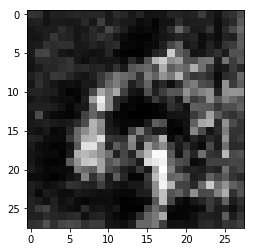

Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.5080... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.4287


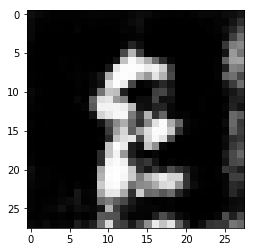

Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.5211... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.6750... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.4675
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 0.4461


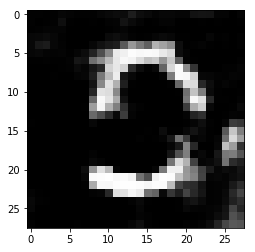

Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.9123... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.6852... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.7264... Generator Loss: 0.4271
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.9158... Generator Loss: 0.4078


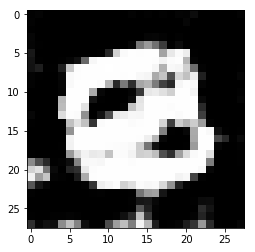

Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 1.5924... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 1.7932... Generator Loss: 0.4083
Epoch 1/2... Discriminator Loss: 1.7085... Generator Loss: 0.4147
Epoch 1/2... Discriminator Loss: 1.9090... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.6287... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.5567


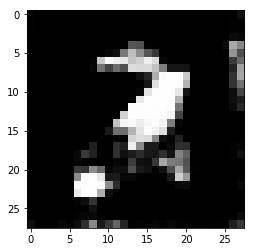

Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.5816... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 1.6273... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.5058... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.7915
Epoch 1/2... Discriminator Loss: 1.8533... Generator Loss: 0.4113


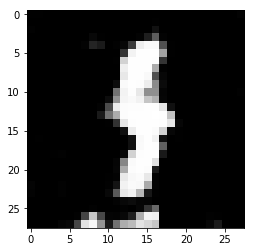

Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.6774... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.5456... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.7813... Generator Loss: 0.8832
Epoch 1/2... Discriminator Loss: 1.6065... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 2.2832... Generator Loss: 0.3404


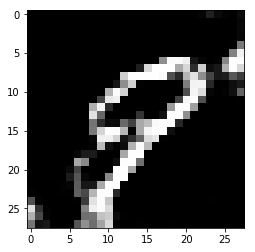

Epoch 1/2... Discriminator Loss: 1.8677... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 1.8595... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 1.5998... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.9815... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.8398... Generator Loss: 0.4085


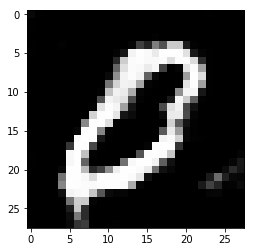

Epoch 1/2... Discriminator Loss: 1.8721... Generator Loss: 0.4061
Epoch 1/2... Discriminator Loss: 1.5892... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.8281... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.6880... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.4851
Epoch 1/2... Discriminator Loss: 2.0839... Generator Loss: 0.3577
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 1.7375... Generator Loss: 0.9289


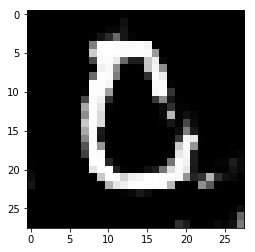

Epoch 1/2... Discriminator Loss: 1.5783... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.9837... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.4422
Epoch 1/2... Discriminator Loss: 1.6319... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.8984... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.4589


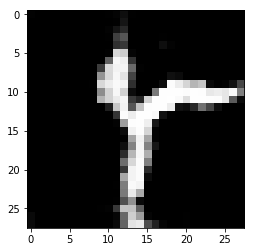

Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.7651... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 0.5541
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.5336... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.8604... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.8457... Generator Loss: 0.4175


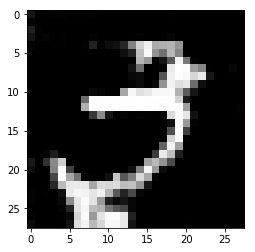

Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.8641... Generator Loss: 0.4009
Epoch 1/2... Discriminator Loss: 1.5968... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.6975... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 1.7994... Generator Loss: 0.4438
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.6284


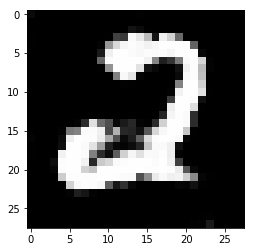

Epoch 1/2... Discriminator Loss: 1.8226... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 2.0538... Generator Loss: 1.3826
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.9438... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.5306... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.7497... Generator Loss: 0.4359
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.5440


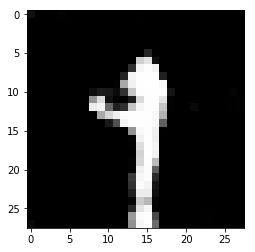

Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 2.2865... Generator Loss: 0.3424
Epoch 1/2... Discriminator Loss: 1.9924... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.9870... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 2.0062... Generator Loss: 0.3699
Epoch 1/2... Discriminator Loss: 1.9609... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 2.0502... Generator Loss: 0.3511
Epoch 1/2... Discriminator Loss: 2.0251... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 1.7095... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.7942... Generator Loss: 0.4050


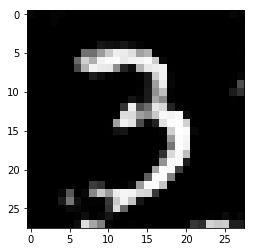

Epoch 1/2... Discriminator Loss: 1.9280... Generator Loss: 0.3663
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 2.0233... Generator Loss: 0.4024
Epoch 1/2... Discriminator Loss: 2.1455... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.9958... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 2.0771... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.6051
Epoch 1/2... Discriminator Loss: 1.5342... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.5706


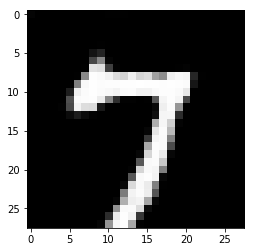

Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 0.4467
Epoch 1/2... Discriminator Loss: 1.6910... Generator Loss: 0.4578
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 2.1440... Generator Loss: 0.3614
Epoch 1/2... Discriminator Loss: 1.8075... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 2.1270... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 2.0277... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.6884... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 2.7235... Generator Loss: 0.3201


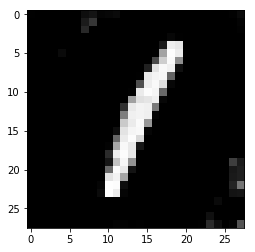

Epoch 1/2... Discriminator Loss: 2.0027... Generator Loss: 0.3503
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.5410
Epoch 1/2... Discriminator Loss: 2.1449... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 2.0826... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 1.8749... Generator Loss: 0.3858
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 2.0536... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.5838


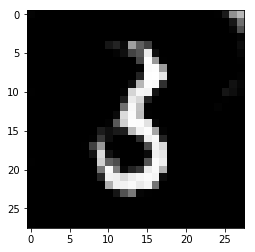

Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.8119... Generator Loss: 0.4095
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 1.7936... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.9128... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.8883... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.7937


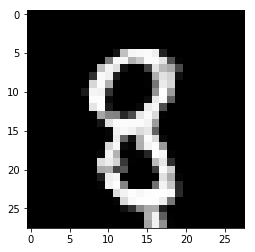

Epoch 1/2... Discriminator Loss: 1.8349... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.9583... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.6733... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 2.2261... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 2.4172... Generator Loss: 0.3380
Epoch 1/2... Discriminator Loss: 1.9847... Generator Loss: 0.3895
Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.9388
Epoch 2/2... Discriminator Loss: 1.6639... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.8644... Generator Loss: 0.4038
Epoch 2/2... Discriminator Loss: 1.7264... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 1.9387... Generator Loss: 0.3557
Epoch 2/2... Discriminator Loss: 2.1277... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 2.0234... Generator Loss: 0.3895
Epoch 2/2.

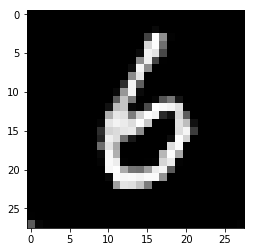

Epoch 2/2... Discriminator Loss: 1.8698... Generator Loss: 0.4536
Epoch 2/2... Discriminator Loss: 2.0200... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.6573... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 2.2443... Generator Loss: 0.3309
Epoch 2/2... Discriminator Loss: 1.8940... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 2.7675... Generator Loss: 0.3398
Epoch 2/2... Discriminator Loss: 1.8614... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.6128... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 2.0186... Generator Loss: 0.3659


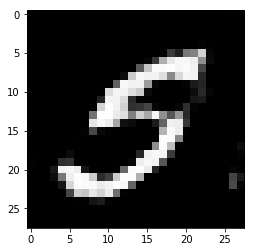

Epoch 2/2... Discriminator Loss: 2.2012... Generator Loss: 0.3975
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.8323... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 1.8873... Generator Loss: 0.4093
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.5625
Epoch 2/2... Discriminator Loss: 2.2285... Generator Loss: 0.3531
Epoch 2/2... Discriminator Loss: 1.7530... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 2.2693... Generator Loss: 0.3718
Epoch 2/2... Discriminator Loss: 1.6237... Generator Loss: 0.4607


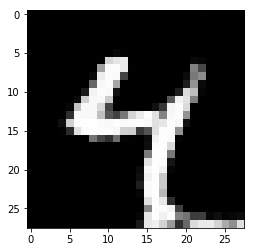

Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 1.8670... Generator Loss: 0.4393
Epoch 2/2... Discriminator Loss: 2.1102... Generator Loss: 0.3923
Epoch 2/2... Discriminator Loss: 2.0247... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.8092... Generator Loss: 0.4414
Epoch 2/2... Discriminator Loss: 1.5877... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 2.4168... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 1.0846... Generator Loss: 1.0994
Epoch 2/2... Discriminator Loss: 1.8034... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 2.0877... Generator Loss: 0.3640


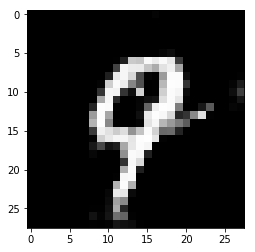

Epoch 2/2... Discriminator Loss: 1.6524... Generator Loss: 0.5342
Epoch 2/2... Discriminator Loss: 1.6079... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 2.0389... Generator Loss: 0.3931
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 1.9628... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 2.1355... Generator Loss: 0.3807
Epoch 2/2... Discriminator Loss: 2.2043... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 1.8329... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 2.0356... Generator Loss: 0.3803


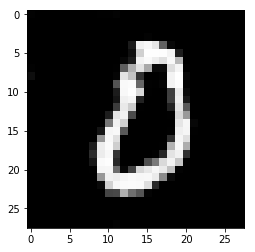

Epoch 2/2... Discriminator Loss: 2.2830... Generator Loss: 0.3402
Epoch 2/2... Discriminator Loss: 1.7891... Generator Loss: 0.4625
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 2.3424... Generator Loss: 0.3507
Epoch 2/2... Discriminator Loss: 1.8887... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 2.4026... Generator Loss: 0.3407
Epoch 2/2... Discriminator Loss: 1.6103... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 2.3165... Generator Loss: 0.3522
Epoch 2/2... Discriminator Loss: 1.8910... Generator Loss: 0.3746


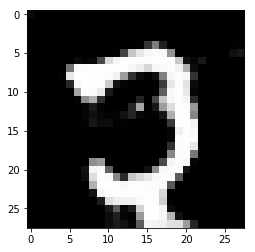

Epoch 2/2... Discriminator Loss: 2.3027... Generator Loss: 0.3757
Epoch 2/2... Discriminator Loss: 2.3278... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.7708... Generator Loss: 0.4619
Epoch 2/2... Discriminator Loss: 1.8385... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 2.1040... Generator Loss: 0.3934
Epoch 2/2... Discriminator Loss: 1.9209... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 2.2911... Generator Loss: 0.3402
Epoch 2/2... Discriminator Loss: 2.1930... Generator Loss: 0.3448
Epoch 2/2... Discriminator Loss: 1.6342... Generator Loss: 0.8772


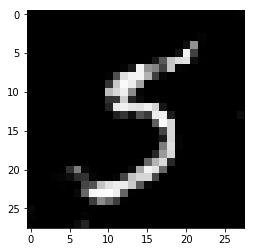

Epoch 2/2... Discriminator Loss: 2.6384... Generator Loss: 0.3293
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 2.7008... Generator Loss: 0.3379
Epoch 2/2... Discriminator Loss: 1.9233... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 1.8112... Generator Loss: 0.4205
Epoch 2/2... Discriminator Loss: 1.8133... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 2.4333... Generator Loss: 0.3601
Epoch 2/2... Discriminator Loss: 2.5347... Generator Loss: 0.3275


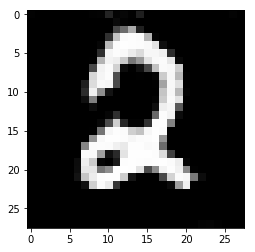

Epoch 2/2... Discriminator Loss: 1.9363... Generator Loss: 0.4292
Epoch 2/2... Discriminator Loss: 2.1708... Generator Loss: 0.3893
Epoch 2/2... Discriminator Loss: 1.5637... Generator Loss: 0.4974
Epoch 2/2... Discriminator Loss: 1.9261... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 2.2332... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 1.6711... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 2.1351... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 2.4418... Generator Loss: 0.3623
Epoch 2/2... Discriminator Loss: 2.5133... Generator Loss: 0.3644
Epoch 2/2... Discriminator Loss: 2.1494... Generator Loss: 0.3764


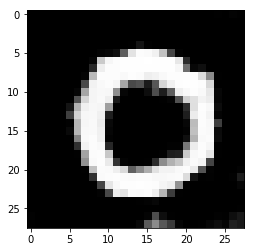

Epoch 2/2... Discriminator Loss: 1.8689... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 2.5818... Generator Loss: 0.3340
Epoch 2/2... Discriminator Loss: 2.0740... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 2.1984... Generator Loss: 0.3653
Epoch 2/2... Discriminator Loss: 1.9214... Generator Loss: 0.4610
Epoch 2/2... Discriminator Loss: 2.3613... Generator Loss: 0.3383
Epoch 2/2... Discriminator Loss: 1.9247... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 2.1113... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 1.5647... Generator Loss: 0.5604


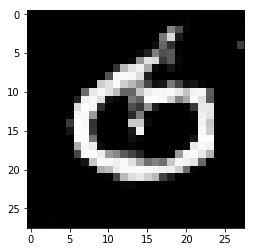

Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.8090... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.9687... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 2.6401... Generator Loss: 0.3360
Epoch 2/2... Discriminator Loss: 2.3611... Generator Loss: 0.3782
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 2.5353... Generator Loss: 0.3493
Epoch 2/2... Discriminator Loss: 2.1792... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 1.8335... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 2.7627... Generator Loss: 0.3297


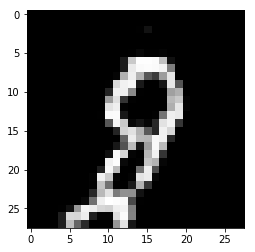

Epoch 2/2... Discriminator Loss: 2.3410... Generator Loss: 0.3675
Epoch 2/2... Discriminator Loss: 1.9068... Generator Loss: 0.4817
Epoch 2/2... Discriminator Loss: 2.7303... Generator Loss: 0.3381
Epoch 2/2... Discriminator Loss: 2.5351... Generator Loss: 0.3432
Epoch 2/2... Discriminator Loss: 2.1464... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 2.4957... Generator Loss: 0.3521
Epoch 2/2... Discriminator Loss: 1.5657... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.8803... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 2.3391... Generator Loss: 0.3470


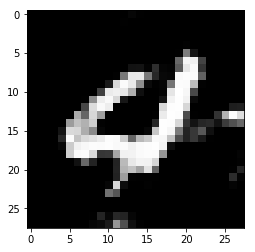

Epoch 2/2... Discriminator Loss: 2.0722... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.9529... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 2.0442... Generator Loss: 0.4025
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 1.6306... Generator Loss: 0.5518
Epoch 2/2... Discriminator Loss: 1.9517... Generator Loss: 0.4440
Epoch 2/2... Discriminator Loss: 2.2329... Generator Loss: 0.3602
Epoch 2/2... Discriminator Loss: 1.9150... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.8233... Generator Loss: 0.4588


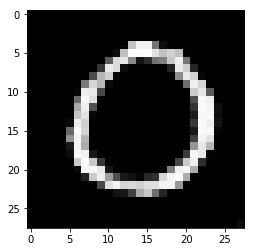

Epoch 2/2... Discriminator Loss: 1.6304... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 2.1455... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.5886... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 2.2147... Generator Loss: 0.3854
Epoch 2/2... Discriminator Loss: 2.2419... Generator Loss: 0.3286
Epoch 2/2... Discriminator Loss: 2.9535... Generator Loss: 0.3205
Epoch 2/2... Discriminator Loss: 1.6436... Generator Loss: 0.5020
Epoch 2/2... Discriminator Loss: 1.6506... Generator Loss: 0.5401
Epoch 2/2... Discriminator Loss: 2.1478... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 1.7153... Generator Loss: 0.5237


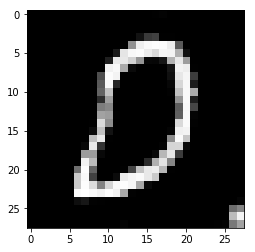

Epoch 2/2... Discriminator Loss: 3.0367... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 2.2464... Generator Loss: 0.3971
Epoch 2/2... Discriminator Loss: 2.0654... Generator Loss: 0.4092
Epoch 2/2... Discriminator Loss: 2.4658... Generator Loss: 0.3704
Epoch 2/2... Discriminator Loss: 1.9501... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 2.1930... Generator Loss: 0.3992
Epoch 2/2... Discriminator Loss: 2.0355... Generator Loss: 0.3750
Epoch 2/2... Discriminator Loss: 2.3688... Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 2.0235... Generator Loss: 0.5604


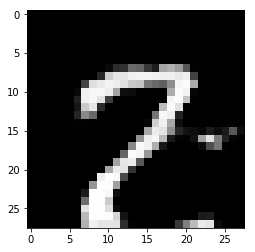

Epoch 2/2... Discriminator Loss: 2.2581... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 3.0727... Generator Loss: 0.3294
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 1.7500... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 2.1154... Generator Loss: 0.3896
Epoch 2/2... Discriminator Loss: 1.7241... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 1.6560... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 2.2387... Generator Loss: 0.3717
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.5125
Epoch 2/2... Discriminator Loss: 2.0827... Generator Loss: 0.3884


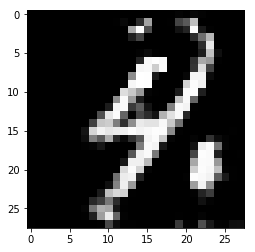

Epoch 2/2... Discriminator Loss: 2.1976... Generator Loss: 0.3779
Epoch 2/2... Discriminator Loss: 2.4169... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.7885... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 2.2010... Generator Loss: 0.3913
Epoch 2/2... Discriminator Loss: 1.8454... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 2.2361... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 3.0725... Generator Loss: 0.3222
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 3.3112... Generator Loss: 0.3408
Epoch 2/2... Discriminator Loss: 1.9318... Generator Loss: 0.4591


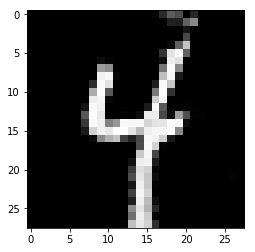

Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 2.4193... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.9240... Generator Loss: 0.4284
Epoch 2/2... Discriminator Loss: 1.6318... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 2.7059... Generator Loss: 0.3523
Epoch 2/2... Discriminator Loss: 2.5224... Generator Loss: 0.3775


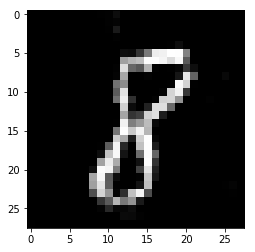

Epoch 2/2... Discriminator Loss: 2.7468... Generator Loss: 0.3619
Epoch 2/2... Discriminator Loss: 2.5388... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 1.6242... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 1.7932... Generator Loss: 0.4710
Epoch 2/2... Discriminator Loss: 2.5847... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 2.5257... Generator Loss: 0.3332
Epoch 2/2... Discriminator Loss: 2.4988... Generator Loss: 0.3865


In [84]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 2.0042... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6756


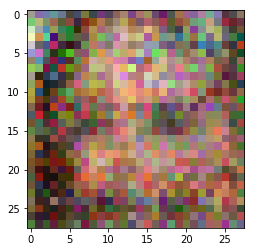

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6819


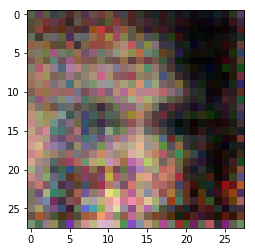

Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 1.0465


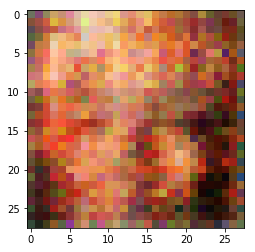

Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6679


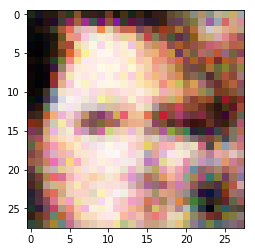

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8228


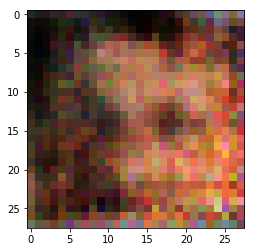

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6259


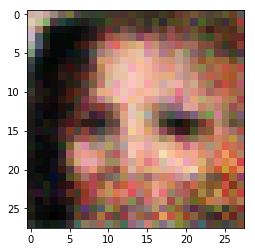

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5664


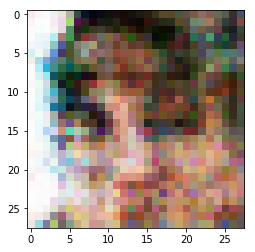

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6901


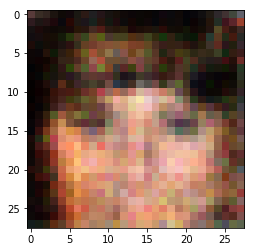

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.9767


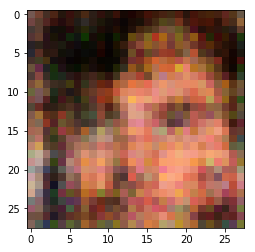

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7693


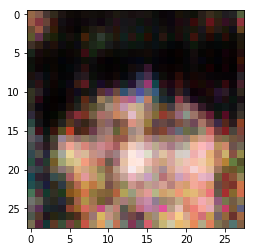

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7701


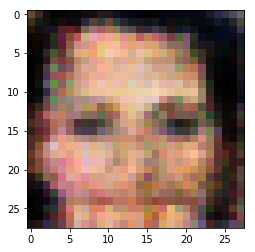

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6439


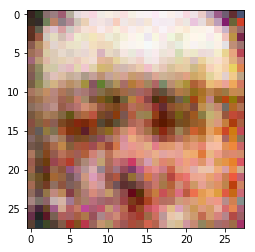

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5925


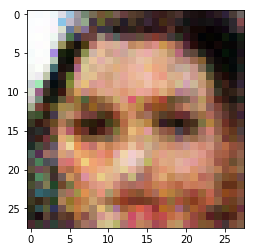

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7012


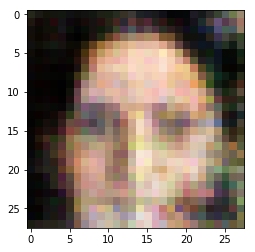

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8398


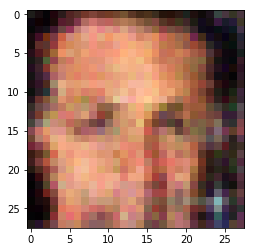

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6296


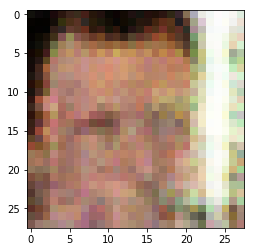

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7517


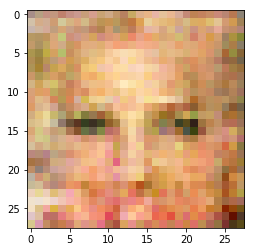

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8140


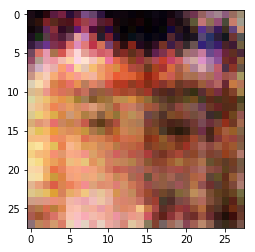

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6777


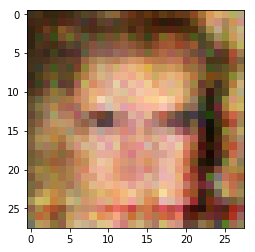

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8763


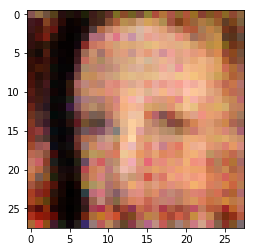

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7487


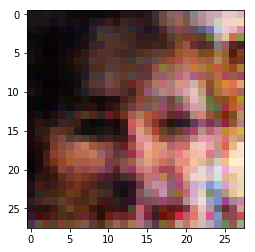

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7008


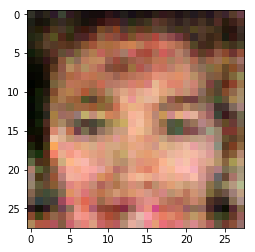

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8202


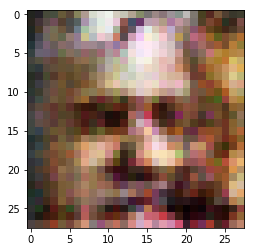

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7970


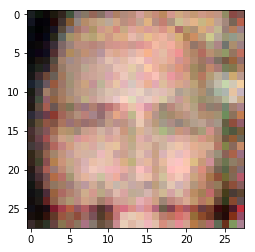

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7788


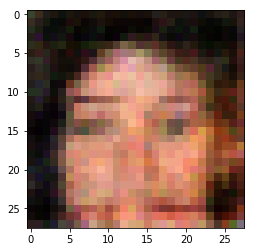

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6868


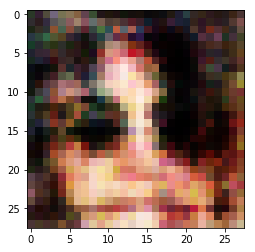

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7113


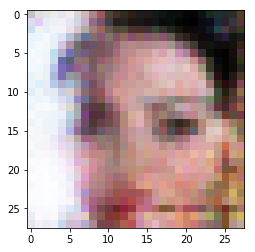

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7189


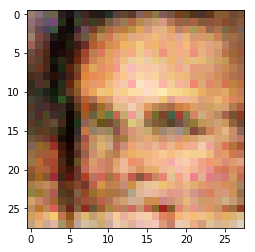

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8266


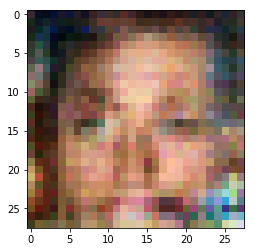

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7553


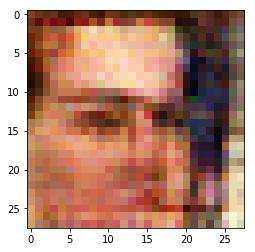

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8429


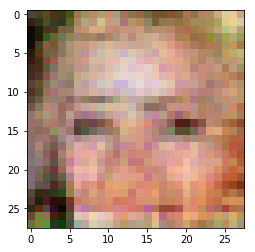

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6810


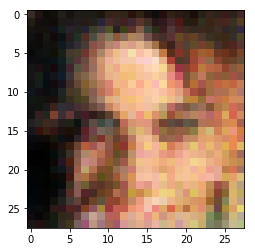

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.8042


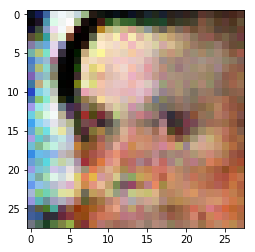

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7820


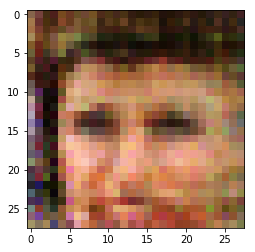

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7844


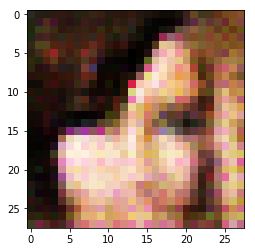

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7748


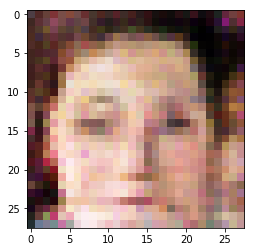

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8349


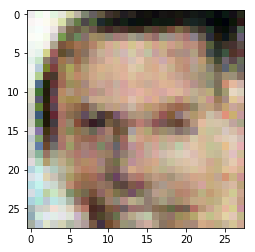

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8182


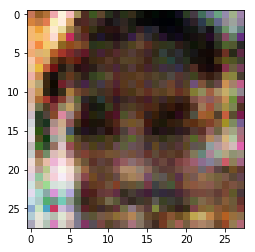

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8421


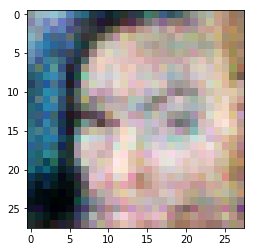

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6819


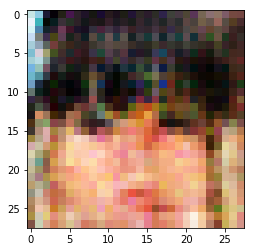

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8044


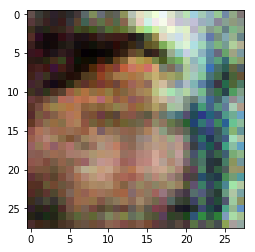

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7223


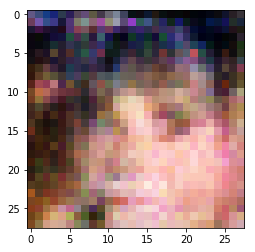

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7292


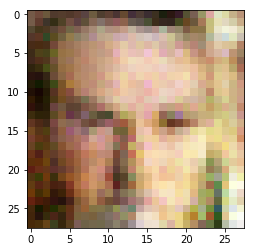

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7437


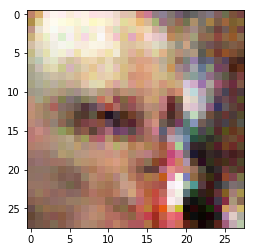

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6478


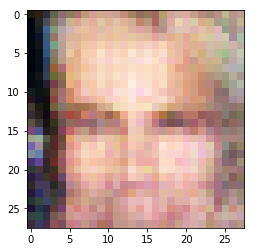

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7498


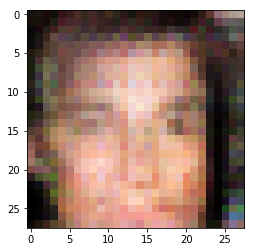

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7648


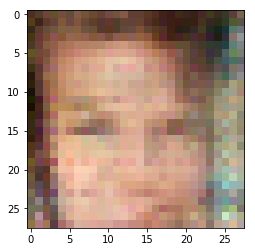

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7755


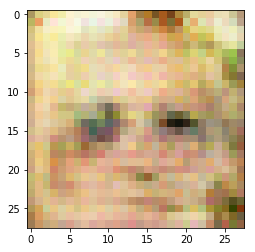

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7301


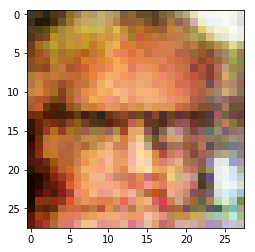

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7788


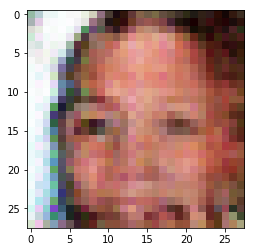

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6983


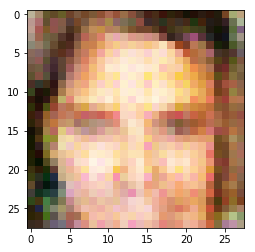

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7113


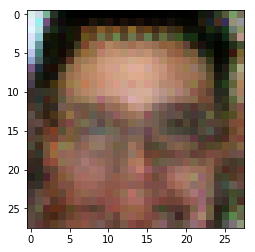

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7241


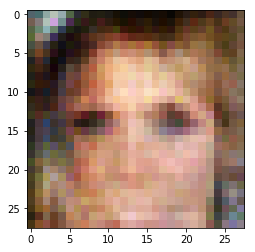

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7497


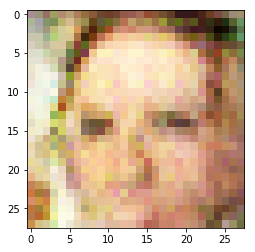

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7987


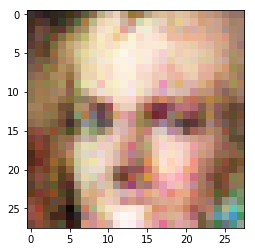

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7253


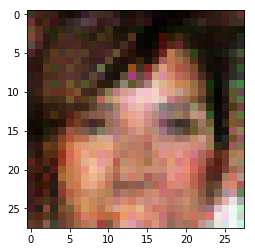

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7716


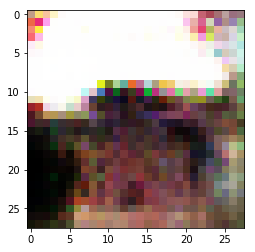

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8123


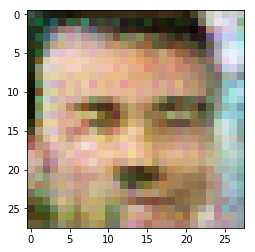

Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7808


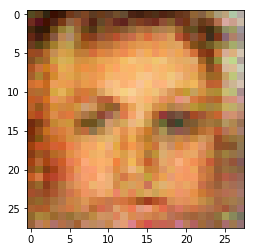

Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7603


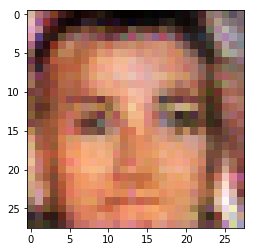

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7093


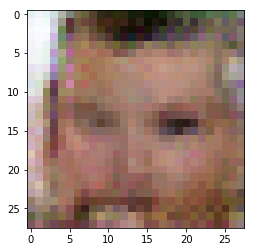

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7042


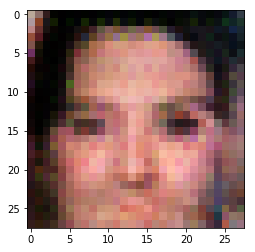

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7364


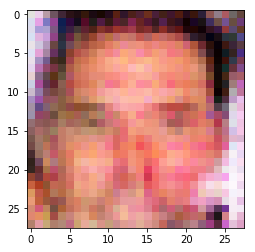

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7875


In [85]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.